# Pretrained DCGAN model to generate art

### Import libraries

In [1]:
import numpy as np
import torch
import torchvision.utils as vutils
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

### Set code size and device

In [2]:
code_size = 100 # Size of the input noise vector for the generator
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Use gpu if available

### Define the generator network

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # in, out, kernel, stride, padding
        self.convt1 = nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False) # 4x4x512
        self.convt2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False) # 8x8x256
        self.convt3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False) # 16x16x128
        self.convt4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False) # 32x32x64
        self.convt5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False) # 64x64x3
        
        self.bn1 = nn.BatchNorm2d(64*8)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.bn4 = nn.BatchNorm2d(64)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.convt1(x)))
        x = F.relu(self.bn2(self.convt2(x)))
        x = F.relu(self.bn3(self.convt3(x)))
        x = F.relu(self.bn4(self.convt4(x)))
        x = self.convt5(x).tanh()
        return x

### Function for model loading

In [4]:
def load_model(model_path, trained_on):
    '''
    Loads a model saved at model_path on device marker
    parameters:
        model_path: string indicating where is the model (.pt or .pth)
        trained_on: string indicating if the model was trained on a cpu ('cpu') or gpu ('cuda:0')
    output:
        model: Trained generator model instance
    VERY IMPORTANT: Make sure to call input = input.to(device)
    on any input tensors that you feed to the model if loading on gpu!!!
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = Generator()
    if str(device) == trained_on:
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

### Load the model
Use the path to the model that you want to use, in the folder `misc` there is a pretrained one.

In [5]:
loaded_gen = load_model('../misc/gpu_trained_generator_19_7_14_11.pth', 'cuda:0')

### Generate a fake vector
By default there will be 64 images generated.

In [6]:
default_size = 64
noise = torch.randn(default_size, code_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = loaded_gen(noise).cpu()

### Plot the generated images

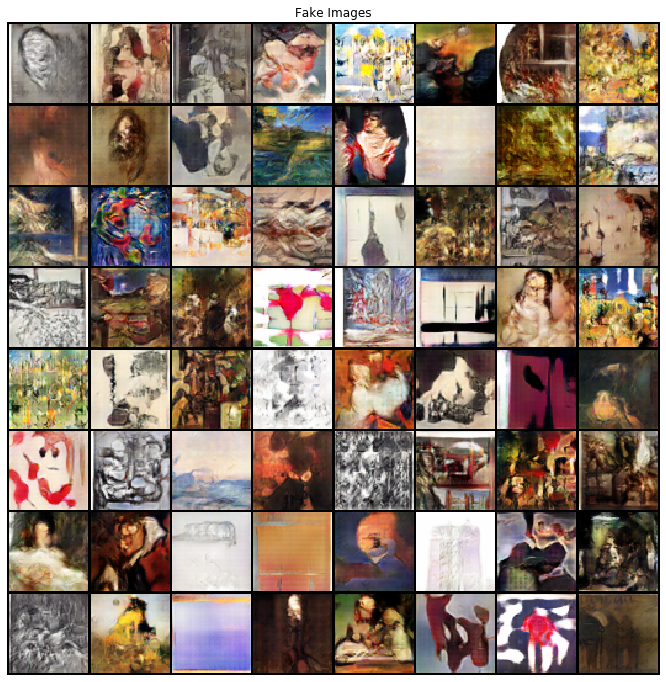

In [7]:
plt.figure(figsize = (12,12))
plt.axis("off")
plt.title("Fake Images")
generated = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.imshow(np.transpose(generated, (1,2,0)))